In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

# Correct path to the file within the dataset
file_path = "IMDB Dataset.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews",
    file_path,
    pandas_kwargs={"encoding": "utf-8"}
)

print(df.head())
print(df.shape)


/tmp/ipykernel_36/374076165.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
(50000, 2)


                                              review sentiment  review_length  \
0  One of the other reviewers has mentioned that ...  positive            154   
1  A wonderful little production. <br /><br />The...  positive             86   
2  I thought this was a wonderful way to spend ti...  positive             82   
3  Basically there's a family where a little boy ...  negative             63   
4  Petter Mattei's "Love in the Time of Money" is...  positive            120   

                                        clean_tokens  
0  [one, reviewers, mentioned, watching, episode,...  
1  [wonderful, little, production, filming, techn...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, family, little, boy, jake, thinks,...  
4  [petter, mattei, love, time, money, visually, ...  
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='review_length', ylabel='Count'>

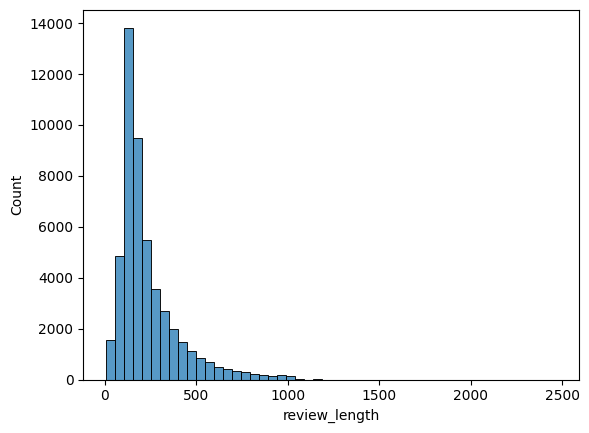

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print(df.head())
print(df['sentiment'].value_counts())

# Length distribution
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=50)

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)                # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text)            # Remove non-alphabet
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

df['clean_tokens'] = df['review'].apply(clean_text)



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
import gensim.downloader as api
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load pretrained model
w2v_model = api.load("word2vec-google-news-300")

# Average word vector for each review
def get_avg_vector(tokens, model, dim=300):
    vectors = [model[word] for word in tokens if word in model]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0.0] * dim

X = df['clean_tokens'].apply(lambda x: get_avg_vector(x, w2v_model))
X = list(X)
y = df['sentiment'].map({'positive': 1, 'negative': 0})

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy (Pretrained W2V):", accuracy_score(y_test, y_pred))


KeyboardInterrupt: 

In [ ]:
#Custom Skip-Gram Word2Vec
from gensim.models import Word2Vec

# Skip-Gram: sg=1
skipgram_model = Word2Vec(sentences=df['clean_tokens'], vector_size=100, window=5, min_count=2, sg=1)

X_skip = df['clean_tokens'].apply(lambda x: get_avg_vector(x, skipgram_model.wv, dim=100))
X_train, X_test, y_train, y_test = train_test_split(list(X_skip), y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print("Accuracy (Skip-gram):", accuracy_score(y_test, clf.predict(X_test)))


In [ ]:
#Custom CBOW Word2Vec
# CBOW: sg=0
cbow_model = Word2Vec(sentences=df['clean_tokens'], vector_size=100, window=5, min_count=2, sg=0)

X_cbow = df['clean_tokens'].apply(lambda x: get_avg_vector(x, cbow_model.wv, dim=100))
X_train, X_test, y_train, y_test = train_test_split(list(X_cbow), y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print("Accuracy (CBOW):", accuracy_score(y_test, clf.predict(X_test)))


In [ ]:
#Custom FastText Model
from gensim.models import FastText

fasttext_model = FastText(sentences=df['clean_tokens'], vector_size=100, window=5, min_count=2)

X_ft = df['clean_tokens'].apply(lambda x: get_avg_vector(x, fasttext_model.wv, dim=100))
X_train, X_test, y_train, y_test = train_test_split(list(X_ft), y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print("Accuracy (FastText):", accuracy_score(y_test, clf.predict(X_test)))



In [ ]:
# Use the best model (replace with whichever had highest accuracy, e.g., FastText)
best_model = clf  # From FastText or any other section

# Predict on test set
y_pred = best_model.predict(X_test)

# Create a DataFrame to analyze predictions
test_df = pd.DataFrame({
    'review': df.iloc[y_test.index]['review'].values,
    'true_sentiment': y_test.values,
    'predicted_sentiment': y_pred
})

# Map 0/1 back to label
label_map = {1: 'positive', 0: 'negative'}
test_df['true_label'] = test_df['true_sentiment'].map(label_map)
test_df['predicted_label'] = test_df['predicted_sentiment'].map(label_map)

test_df.head()

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')


In [ ]:
# False Positives and False Negatives
false_positives = test_df[(test_df['true_label'] == 'negative') & (test_df['predicted_label'] == 'positive')]
false_negatives = test_df[(test_df['true_label'] == 'positive') & (test_df['predicted_label'] == 'negative')]

print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

print("\n🔸 Sample False Positives:")
for i in range(3):
    print(f"\nReview:\n{false_positives.iloc[i]['review'][:500]}...\nTrue: Negative, Predicted: Positive")

print("\n🔸 Sample False Negatives:")
for i in range(3):
    print(f"\nReview:\n{false_negatives.iloc[i]['review'][:500]}...\nTrue: Positive, Predicted: Negative")


In [ ]:
df['review_length'] = df['clean_tokens'].apply(len)

sns.boxplot(data=df, x='sentiment', y='review_length')
plt.title("Distribution of Token Counts by Sentiment")
plt.show()

# Word clouds (optional)
from wordcloud import WordCloud

positive_reviews = df[df['sentiment'] == 'positive']['clean_tokens'].explode().values
negative_reviews = df[df['sentiment'] == 'negative']['clean_tokens'].explode().values

positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)

# WordCloud
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(background_color="white").generate(positive_text))
plt.title("Positive Reviews WordCloud")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(background_color="white").generate(negative_text))
plt.title("Negative Reviews WordCloud")
plt.axis("off")
plt.show()
